# Introduction

The notebook is a demo for usage of two regularization utils: l0_layer, l0_dense. We use very simple 2-layer MLP architecture to build Autoencoders for reconstructing MNIST dataset. L0 is applied here in two cases: 
- Experiment1: regularize on the weights and biases on the the two layers of the AE
- Experiment2: regularize on the latent activation of the AE


L0 regularization [(Louizos et al 2017)](https://arxiv.org/abs/1712.01312) is an approximate regularization being done by creating a surrogate mask which will alter the original architecture of the networks, for details, one can have look at the interactive tensorboard created in both of the experiments

### Todo:
1. weight evaluation for L0LMLP_AE
2. maybe other datasets 

# Preparation

In [1]:
""" Auto Encoder Example.
Kuan: The template is borrowed from some github REPO

Using an auto encoder on MNIST handwritten digits.
References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
"""



' Auto Encoder Example.\nUsing an auto encoder on MNIST handwritten digits.\nReferences:\n    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based\n    learning applied to document recognition." Proceedings of the IEEE,\n    86(11):2278-2324, November 1998.\nLinks:\n    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/\n'

In [4]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tb_graph_jupyter import show_graph
# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)


# dense_test = tf.layers.dense
from l0_dense import l0_dense
from l0_layer import l0_layer

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
# Parameters
learning_rate = 0.01
training_epochs = 100
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)
reg_const = 1e-6 # ~ 1e3/n == 1e5-1e6 for MNIST

total_batch = int(mnist.train.num_examples/batch_size)

# Neural Nets Modules:

In [9]:
def l0_encoder(x, is_training):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = l0_dense(x, n_hidden_1, 
                       is_training=is_training,
                       activation=tf.nn.relu,
                       kernel_regularization_scale=reg_const,
                       bias_regularization_scale=reg_const)    
    return layer_1

def l0_decoder(x, is_training):
    layer_1 = l0_dense(x, n_input, 
                       is_training=is_training,
                       kernel_regularization_scale=reg_const,
                       bias_regularization_scale=reg_const)
    return layer_1

# Experiment1: L0MLP_AE:

### L0MLP_AE: Build Graph and Graph Visualization (TensorBoard)

In [19]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():    
    X = tf.placeholder("float", [None, n_input])
    is_training = tf.placeholder(tf.bool, [], name='is_training')    
    # Construct model
    with tf.variable_scope('encoder'):
        encoder_op = l0_encoder(X, is_training)    
    
    with tf.variable_scope('decoder'):
        decoder_op = l0_decoder(encoder_op, is_training)

    # Prediction
    y_pred = decoder_op
    # Targets (Labels) are the input data.
    y_true = X

    # Define loss and optimizer, minimize the squared error
    losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    print(losses)
    
    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2)) + tf.reduce_sum(losses)
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()
    # Launch the graph
    # Using InteractiveSession (more convenient while using Notebooks)
    sess = tf.InteractiveSession()
    sess.run(init)
    
tf.summary.FileWriter("logs", g).close()

[<tf.Tensor 'encoder/l0_dense/kernel/Regularizer/l0_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'encoder/l0_dense/bias/Regularizer/l0_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'decoder/l0_dense/kernel/Regularizer/l0_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'decoder/l0_dense/bias/Regularizer/l0_regularizer:0' shape=() dtype=float32>]


In [20]:
show_graph(g)

### L0MLP_AE: Training

In [ ]:
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, is_training: True})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(c))

print("Optimization Finished!")

### L0MLP_AE: Evaluation

/is/sg/klee/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


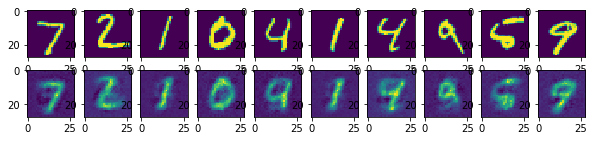

In [22]:
# Applying encode and decode over test set
encode_decode = sess.run(y_pred, feed_dict={X: mnist.test.images[:examples_to_show], is_training: False})
encoded_training = sess.run(encoder_op, 
                            feed_dict={X: mnist.test.images[:examples_to_show], is_training: True})
encoded_pred= sess.run(encoder_op, 
                       feed_dict={X: mnist.test.images[:examples_to_show], is_training: False})
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    
f.show()
plt.show()

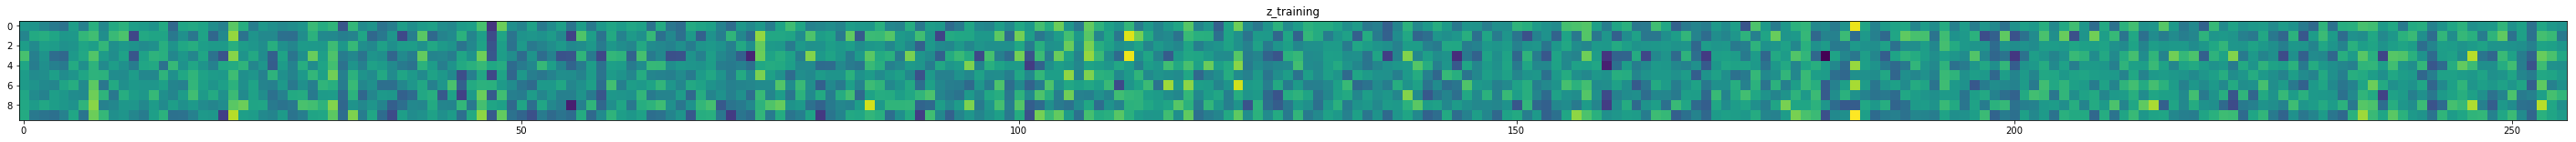

In [24]:
# latents for training
fig2 = plt.figure(figsize=(50, 300))
plt.imshow(encoded_training)
plt.title('z_training')

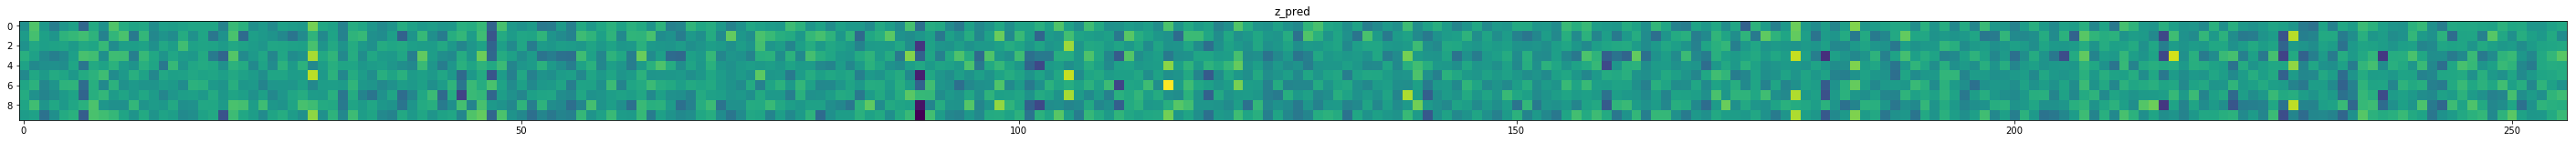

In [23]:
# latents for prediction
fig = plt.figure(figsize=(50, 300))
plt.imshow(encoded_pred)
plt.title('z_pred')

In [ ]:
print(encoded_pred)

# Experiement2: MLPAE with L0 regularized representation (L0L_AE)

### L0L_AE: Build Graph and Graph Visualization (TensorBoard)

In [27]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():    
    X = tf.placeholder("float", [None, n_input])
    is_training = tf.placeholder(tf.bool, [], name='is_training')    
    # Construct model
    with tf.variable_scope('encoder'):
        encoder_op = tf.layers.dense(X, n_hidden_1, activation=tf.nn.relu)    
    encoder_op = l0_layer(encoder_op, reg_const, is_training)
    with tf.variable_scope('decoder'):
        decoder_op = tf.layers.dense(encoder_op, n_input)

    # Prediction
    y_pred = decoder_op
    # Targets (Labels) are the input data.
    y_true = X

    # Define loss and optimizer, minimize the squared error
    losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    print(losses)
    
    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2)) + tf.reduce_sum(losses)
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()
    # Launch the graph
    # Using InteractiveSession (more convenient while using Notebooks)
    sess = tf.InteractiveSession()
    sess.run(init)
    
tf.summary.FileWriter("logs", g).close()

[<tf.Tensor 'l0__layer/l0_regularizer:0' shape=() dtype=float32>]


In [28]:
show_graph(g)

### L0L_AE: Training

In [30]:
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, is_training: True})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(c))

print("Optimization Finished!")

Epoch: 0001 cost= 0.029452801
Epoch: 0002 cost= 0.030833416
Epoch: 0003 cost= 0.031522155
Epoch: 0004 cost= 0.030153636
Epoch: 0005 cost= 0.031913389
Epoch: 0006 cost= 0.030807307
Epoch: 0007 cost= 0.030488804
Epoch: 0008 cost= 0.034269456
Epoch: 0009 cost= 0.040244021
Epoch: 0010 cost= 0.028709969
Optimization Finished!


### L0L_AE: Evaluation

/is/sg/klee/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


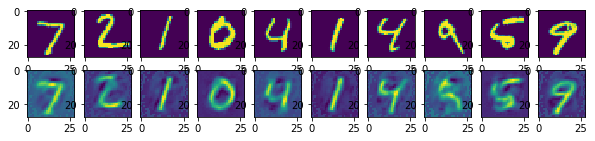

In [31]:
# Applying encode and decode over test set
encode_decode = sess.run(y_pred, feed_dict={X: mnist.test.images[:examples_to_show], is_training: False})
encoded_training = sess.run(encoder_op, 
                            feed_dict={X: mnist.test.images[:examples_to_show], is_training: True})
encoded_pred= sess.run(encoder_op, 
                       feed_dict={X: mnist.test.images[:examples_to_show], is_training: False})
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    
f.show()
plt.show()

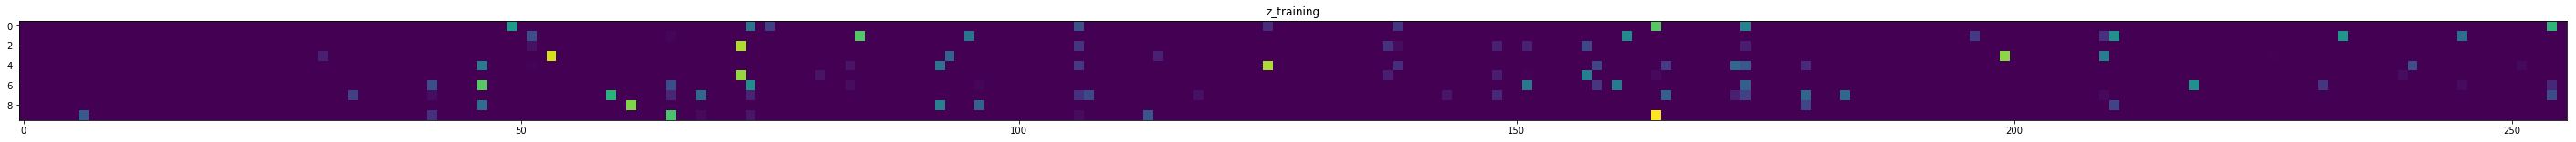

In [33]:
# latents for training
fig2 = plt.figure(figsize=(50, 300))
plt.imshow(encoded_training)
plt.title('z_training')

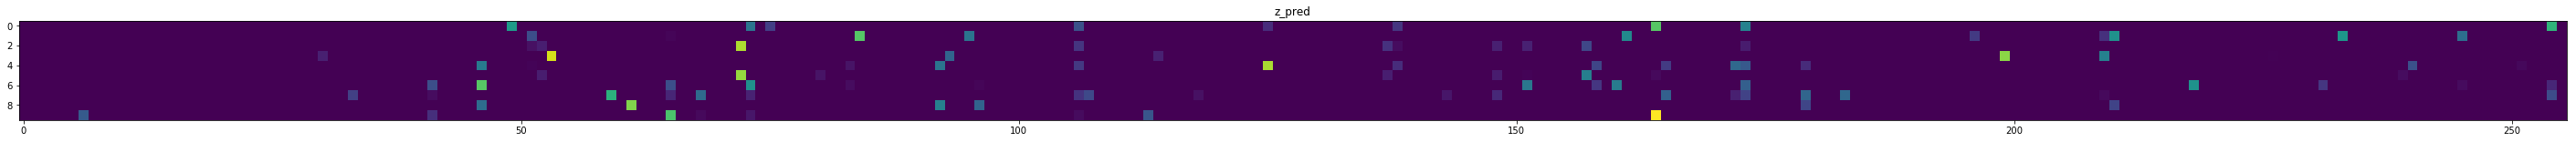

In [32]:
# latents for prediction
fig = plt.figure(figsize=(50, 300))
plt.imshow(encoded_pred)
plt.title('z_pred')